<a href="https://colab.research.google.com/github/ask350/UM-Projects/blob/main/Animal%20Classification/Animal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1 - Requirements and data download

!pip install gdown split_folders tensorflow pillow seaborn --quiet

import gdown, splitfolders, zipfile, os, json, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

url = "https://drive.google.com/file/d/1wYI97Ne35zFL6XRVDiDC9VVgSnHPqNaY/view?usp=sharing"
output = "animalclass_dataset.zip"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1wYI97Ne35zFL6XRVDiDC9VVgSnHPqNaY
From (redirected): https://drive.google.com/uc?id=1wYI97Ne35zFL6XRVDiDC9VVgSnHPqNaY&confirm=t&uuid=bb72c031-978e-4f94-b3e2-46ebd7216809
To: /content/animalclass_dataset.zip
100%|██████████| 38.2M/38.2M [00:00<00:00, 58.8MB/s]


'animalclass_dataset.zip'

In [2]:
# 2 - Unzip data

with zipfile.ZipFile("animalclass_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

print("✅ Dataset extracted successfully!")
print("📁 Folder structure inside 'dataset':", os.listdir("dataset"))

# Auto-detect dataset folder
root_dir = "dataset"
subfolders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
input_folder = os.path.join(root_dir, subfolders[0])
print(f"📂 Using detected dataset folder: {input_folder}")

✅ Dataset extracted successfully!
📁 Folder structure inside 'dataset': ['animlalclass_dataset']
📂 Using detected dataset folder: dataset/animlalclass_dataset


In [3]:
# 3 - split dataset into train, val, test

splitfolders.ratio(input_folder, output="split_data", seed=42, ratio=(0.7, 0.2, 0.1))
print("✅ Data split into train/validation/test folders successfully!")

train_dir = "split_data/train"
val_dir   = "split_data/val"
test_dir  = "split_data/test"


Copying files: 1944 files [00:00, 7534.72 files/s]

✅ Data split into train/validation/test folders successfully!


In [4]:
# 4 - Data Generators

img_size = (160, 160)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_gen   = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_gen  = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 1354 images belonging to 15 classes.
Found 383 images belonging to 15 classes.
Found 207 images belonging to 15 classes.


In [5]:
# Save class names
class_names = sorted(os.listdir(train_dir))
with open("class_names.txt", "w") as f:
    json.dump(class_names, f)

print("✅ Classes:", class_names)

✅ Classes: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']


In [6]:
# 5 - Build CNN model

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(160,160,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(512, (3,3), activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling2D(),

    Dropout(0.35),
    Dense(256, activation='relu'),
    Dropout(0.35),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1)

history = model.fit(train_gen, validation_data=val_gen, epochs=60, callbacks=[early_stop, reduce_lr])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 169s 4s/step - accuracy: 0.1526 - loss: 3.0048 - val_accuracy: 0.0757 - val_loss: 3.2848 - learning_rate: 0.0010
Epoch 2/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.2306 - loss: 2.5380 - val_accuracy: 0.1018 - val_loss: 3.9969 - learning_rate: 0.0010
Epoch 3/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.2928 - loss: 2.3999 - val_accuracy: 0.0731 - val_loss: 4.7659 - learning_rate: 0.0010
Epoch 4/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.3219 - loss: 2.0989 - val_accuracy: 0.0705 - val_loss: 5.9604 - learning_rate: 0.0010
Epoch 5/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.3542 - loss: 2.0691 - val_accuracy: 0.0783 - val_loss: 7.7148 - learning_rate: 0.0010
Epoch 6/60
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3234 - loss: 2.0713
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
43/43 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.3239 - loss: 2.0704 - val_accura

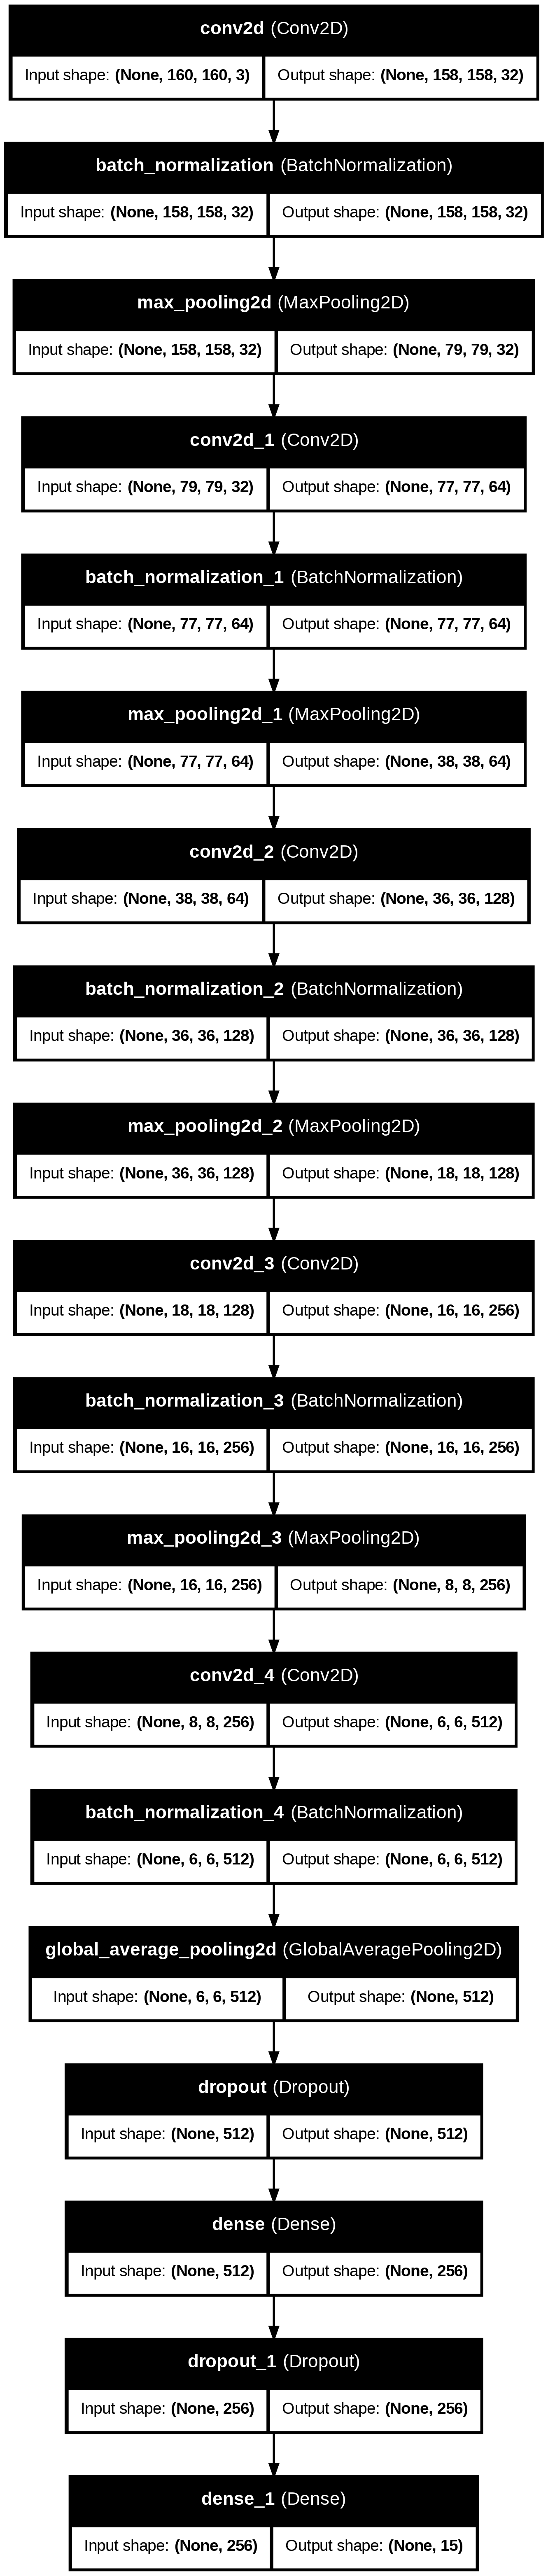

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import plot_model

# Save architecture diagram
plot_model(model, to_file='cnn_architecture.png', show_shapes=True, show_layer_names=True)

# In Colab: display the image
from IPython.display import Image
Image(filename='cnn_architecture.png', width=500)

In [9]:

# 6 - Evaluate

val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 724ms/step - accuracy: 0.8767 - loss: 0.5105
Validation Accuracy: 86.42%


In [10]:
# 7 - Save the trained model to Drive
model.save("animal_classifier_model.keras")
print("Model saved")


Model saved


✅ Model Input Shape: (160, 160)
📂 Found 15 classes in split_data/test


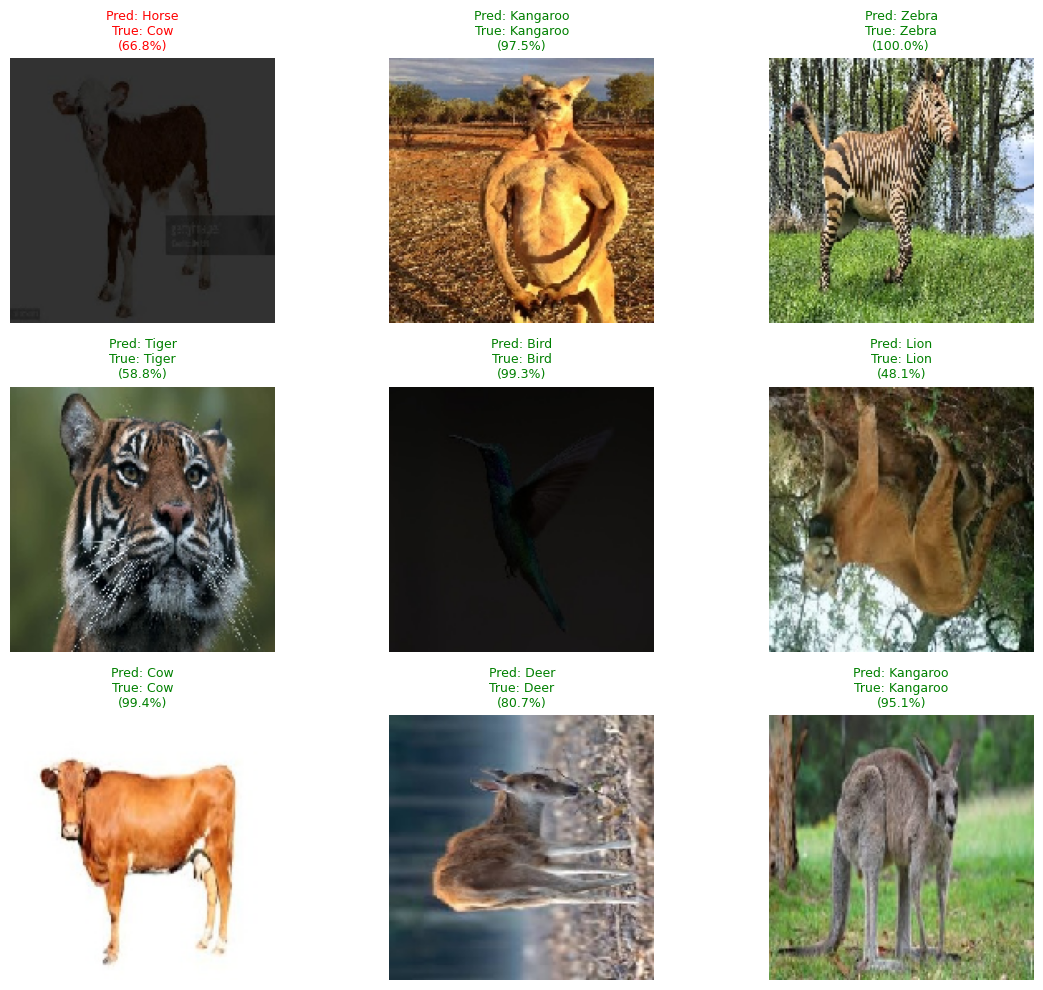

In [11]:
# 8 - PREDICTION GRID VISUALISATION

model = tf.keras.models.load_model("animal_classifier_model.keras")
with open("class_names.txt", "r") as f:
    class_names = json.load(f)

input_shape = model.input_shape[1:3]
print(f"✅ Model Input Shape: {input_shape}")

def visualize_predictions_grid(model, data_dir, class_names, grid_size=(3, 3)):
    all_classes = sorted(os.listdir(data_dir))
    print(f"📂 Found {len(all_classes)} classes in {data_dir}")

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 10))
    axes = axes.flatten()

    for ax in axes:
        chosen_class = random.choice(all_classes)
        class_path = os.path.join(data_dir, chosen_class)
        img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not img_files: continue

        random_img = random.choice(img_files)
        img_path = os.path.join(class_path, random_img)

        img = keras_image.load_img(img_path, target_size=input_shape)
        img_array = keras_image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        preds = model.predict(img_array, verbose=0)
        pred_idx = np.argmax(preds[0])
        pred_class = class_names[pred_idx]
        confidence = np.max(preds[0]) * 100

        ax.imshow(img)
        ax.axis("off")
        ax.set_title(
            f"Pred: {pred_class}\nTrue: {chosen_class}\n({confidence:.1f}%)",
            fontsize=9,
            color=("green" if pred_class == chosen_class else "red")
        )

    plt.tight_layout()
    plt.show()

# Run grid
visualize_predictions_grid(model, test_dir, class_names, grid_size=(3, 3))


Found 207 images belonging to 15 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 620ms/step


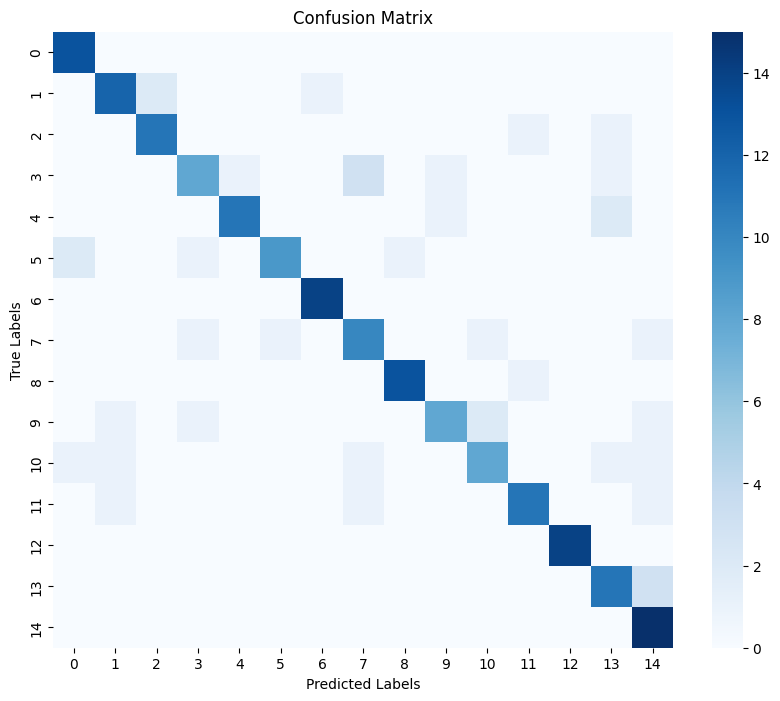

📊 Classification Report:
               precision    recall  f1-score   support

        Bear      0.812     1.000     0.897        13
        Bird      0.800     0.800     0.800        15
         Cat      0.846     0.846     0.846        13
         Cow      0.727     0.571     0.640        14
        Deer      0.917     0.786     0.846        14
         Dog      0.900     0.692     0.783        13
     Dolphin      0.933     1.000     0.966        14
    Elephant      0.667     0.714     0.690        14
     Giraffe      0.929     0.929     0.929        14
       Horse      0.800     0.615     0.696        13
    Kangaroo      0.727     0.615     0.667        13
        Lion      0.846     0.786     0.815        14
       Panda      1.000     1.000     1.000        14
       Tiger      0.688     0.786     0.733        14
       Zebra      0.682     1.000     0.811        15

    accuracy                          0.812       207
   macro avg      0.818     0.809     0.808       207


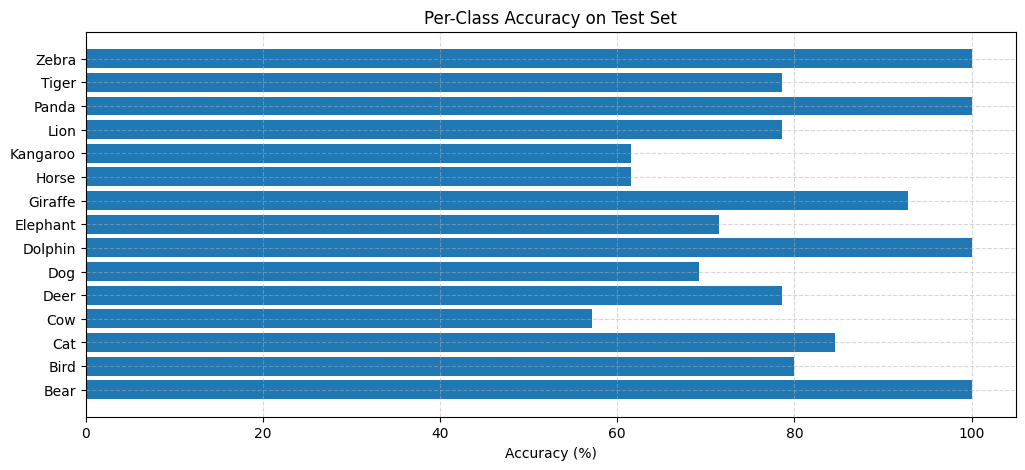

In [13]:
# Confusion matrix, per class accuracy

test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=input_shape, batch_size=32, class_mode='categorical', shuffle=False
)

y_true = test_gen.classes
y_pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

report = classification_report(y_true, y_pred, target_names=class_names, digits=3)
print("📊 Classification Report:\n", report)

cm_sum = np.sum(cm, axis=1, keepdims=True)
class_accuracy = cm.diagonal() / cm_sum.flatten()
plt.figure(figsize=(12, 5))
plt.barh(class_names, class_accuracy * 100)
plt.xlabel("Accuracy (%)")
plt.title("Per-Class Accuracy on Test Set")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
